In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Tomato Disease Classification**

**Building and Training a Convolutional Neural Network (CNN) for Image Classification**

**This section includes:**

Model architecture definition
Data loading and preprocessing
Model training
Visualization of training performance and sample images

**Import all the Dependencies**

In [2]:
# Import TensorFlow and Keras modules for building and training the deep learning model
import tensorflow as tf
from tensorflow.keras import models, layers

# Import matplotlib for visualizing data, training history, and predictions
import matplotlib.pyplot as plt


**Set all the Constants**

In [3]:
# Number of images to process in a single batch
BATCH_SIZE = 16

# Height and width to which all input images will be resized
IMAGE_SIZE = 256

# Number of color channels (3 for RGB)
CHANNELS = 3

# Number of times the model will see the entire training dataset
EPOCHS = 20


**Import data into tensorflow dataset object**

In [4]:
# Load images from the new path for the "Tomato Disease Classification" dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/TOMATOS DISEASE",  # New path to the Tomato Disease dataset in Google Drive
    seed=123,                                  # Seed for reproducibility when shuffling
    shuffle=True,                              # Shuffle the dataset for better training
    image_size=(IMAGE_SIZE, IMAGE_SIZE),       # Resize all images to 256x256
    batch_size=BATCH_SIZE                      # Number of images per batch
)


Found 4499 files belonging to 3 classes.


In [5]:
# Extract the class names (folder names) from the dataset
class_names = dataset.class_names
class_names  # Display the list of class names (e.g., different disease categories)


['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

In [6]:
# Take one batch of images and labels from the dataset
for image_batch, labels_batch in dataset.take(1):
    # Print the shape of the image batch (should be [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS])
    print(image_batch.shape)

    # Print the numeric label values for the batch (each corresponds to a class index)
    print(labels_batch.numpy())


(16, 256, 256, 3)
[1 0 2 0 1 0 2 0 0 1 1 1 2 2 2 2]


**Visualize some of the images from our dataset**

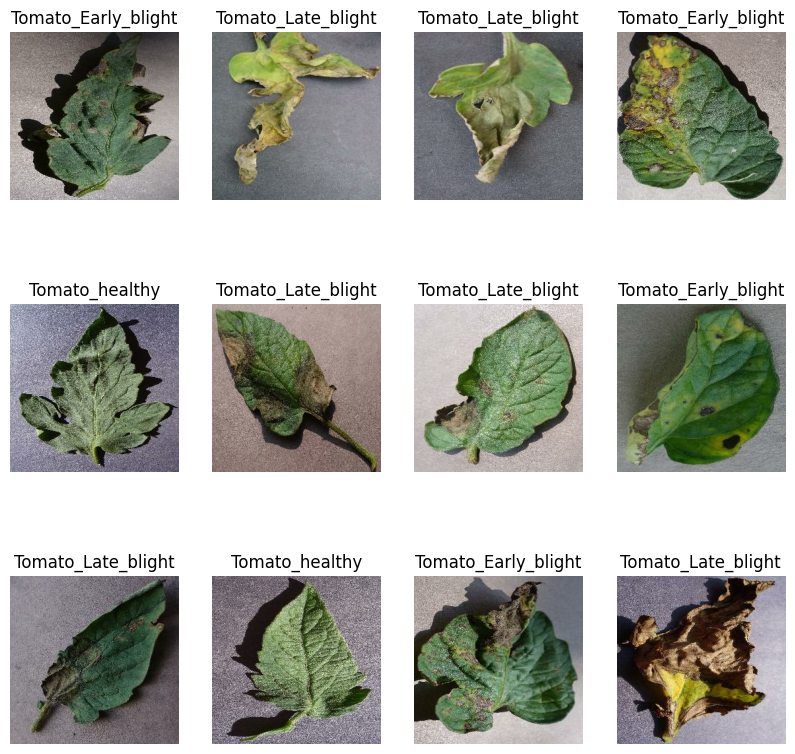

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

**Function to Split Dataset**

**Dataset should be bifurcated into 3 subsets, namely:**

Training: Dataset to be used while training
Validation: Dataset to be tested against while training
Test: Dataset to be tested against after we trained a model

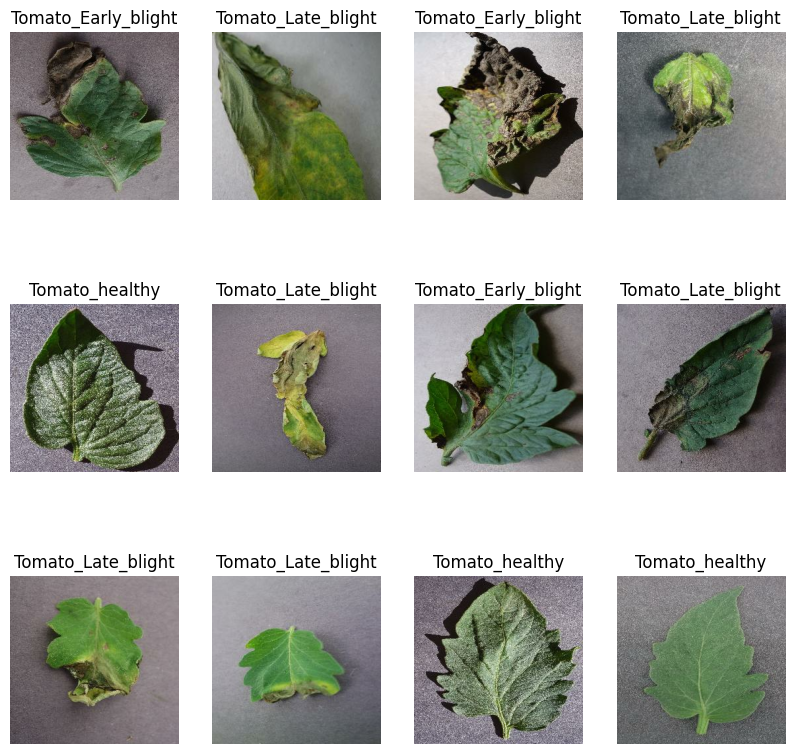

In [8]:
# Set up the figure for visualizing images in a 3x4 grid (12 images)
plt.figure(figsize=(10, 10))

# Loop through the first batch of images and labels
for image_batch, labels_batch in dataset.take(1):  # Take only the first batch
    for i in range(12):  # Loop through 12 images in the batch (you can adjust this number)
        ax = plt.subplot(3, 4, i + 1)  # Create a subplot with 3 rows and 4 columns
        plt.imshow(image_batch[i].numpy().astype("uint8"))  # Convert the image to uint8 for displaying
        plt.title(class_names[labels_batch[i]])  # Display the class name based on the label
        plt.axis("off")  # Hide the axes for better visualization

# Show the images
plt.show()

**Function to Split Dataset**

**Dataset should be bifurcated into 3 subsets, namely:**

Training: Dataset to be used while training

Validation: Dataset to be tested against while training

Test: Dataset to be tested against after we trained a model

In [9]:
# Split dataset into train (80%), val (10%), test (10%)
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)

print(f"Total dataset batches: {dataset_size}")
print(f"Train size (80%): {train_size} batches")
print(f"Validation size (10%): {val_size} batches")
print(f"Test size (10%): {dataset_size - train_size - val_size} batches")

# Create splits using take() and skip()
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size + val_size)


Total dataset batches: 282
Train size (80%): 225 batches
Validation size (10%): 28 batches
Test size (10%): 29 batches


**# Cache, shuffle, and prefetch the datasets for optimized performance**

**Summary:**

**Cache:** Saves the dataset in memory for faster loading in future epochs.

**Shuffle:** Randomizes the data order to prevent the model from learning based on order.

**Prefetch:** Prepares the next batch of data while the model is working on the current batch, speeding up training.

This combination helps in speeding up the overall data pipeline and reduces training time.

In [10]:
# Optimize dataset performance by caching, shuffling, and prefetching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)  # Cache, shuffle, and prefetch training data
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)      # Do the same for validation data
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)    # Do the same for test data


**Building the Model**

**Creating a Layer for Resizing and Normalization**

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it



In [11]:
# Define a sequential model to resize and rescale images for input to the neural network
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Resize images to IMAGE_SIZE x IMAGE_SIZE
    tf.keras.layers.Rescaling(1./255)                  # Rescale pixel values to the range [0, 1]
])


**Data Augmentation**

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.



In [12]:
# Define a sequential model to apply data augmentation to the training images
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip images both horizontally and vertically
    tf.keras.layers.RandomRotation(0.2),                     # Randomly rotate images by a factor of 0.2 radians
])


**Applying Data Augmentation to Train Dataset**

In [13]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

**Model Architecture**

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [14]:
# Define input shape and number of output classes
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

# Build the CNN model properly using Input layer
model = models.Sequential([
    # Define the input shape using an Input layer
    layers.Input(shape=input_shape),

    # Rescale pixel values to [0, 1] and resize all images to IMAGE_SIZE x IMAGE_SIZE
    resize_and_rescale,

    # Apply random data augmentation to improve generalization
    data_augmentation,

    # Convolution + Max Pooling blocks
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten and Fully Connected Layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

In [15]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

**Compiling the Model**

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [16]:
# Compile the model with Adam optimizer and SparseCategoricalCrossentropy loss
model.compile(
    optimizer='adam',  # Adam optimizer is used for its efficiency in training deep learning models
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Loss function for multi-class classification, without logits
    metrics=['accuracy']  # Track accuracy as the evaluation metric
)


In [17]:
# Train the model using the training dataset and validate using the validation dataset
history = model.fit(
    train_ds,  # The training dataset used to train the model
    batch_size=BATCH_SIZE,  # The number of samples per gradient update during training
    validation_data=val_ds,  # The validation dataset to evaluate the model after each epoch
    verbose=1,  # Controls the verbosity of the training process (1 shows progress bar)
    epochs=20,  # The number of times the entire dataset will be passed through the model
)


Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 605s 2s/step - accuracy: 0.5144 - loss: 0.9651 - val_accuracy: 0.6362 - val_loss: 0.8578
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.7789 - loss: 0.5169 - val_accuracy: 0.8147 - val_loss: 0.4604
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 337s 1s/step - accuracy: 0.8308 - loss: 0.3883 - val_accuracy: 0.8036 - val_loss: 0.5157
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - accuracy: 0.8374 - loss: 0.3539 - val_accuracy: 0.8772 - val_loss: 0.3713
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.8457 - loss: 0.3390 - val_accuracy: 0.8527 - val_loss: 0.4239
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - accuracy: 0.8599 - loss: 0.3520 - val_accuracy: 0.8147 - val_loss: 0.5030
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - accuracy: 0.8697 - loss: 0.2923 - val_accuracy: 0.8705 - val_loss: 0.4388
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - accuracy: 0.8901 - loss: 0.2664 - val_accu

In [18]:
# Evaluate the model on test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


29/29 ━━━━━━━━━━━━━━━━━━━━ 59s 351ms/step - accuracy: 0.9420 - loss: 0.2675
Test Accuracy: 93.13%


**Plotting the Accuracy and Loss Curves**

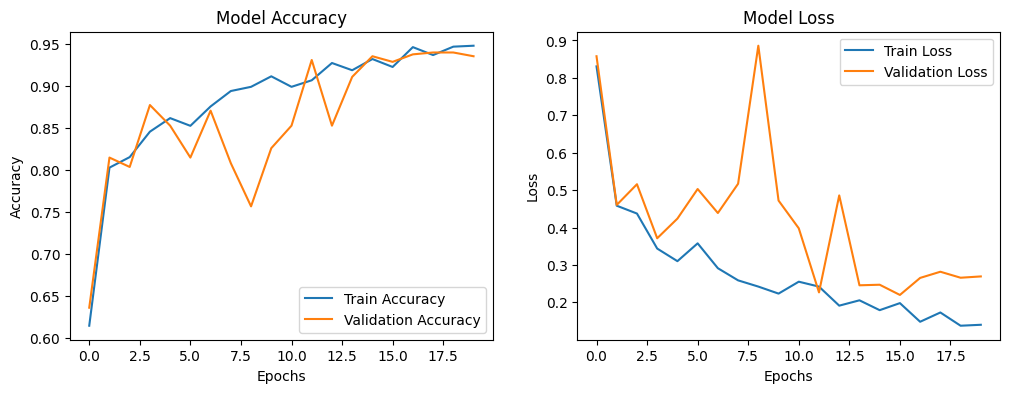

In [19]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot (optional)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



**Run prediction on a sample image**

First image to predict:


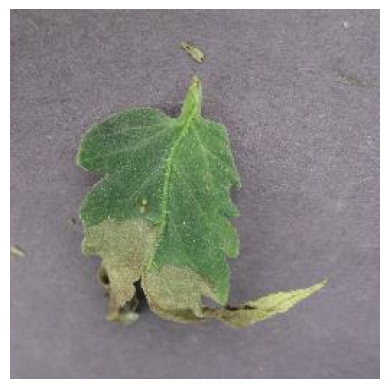

Actual label: Tomato_Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
Predicted label: Tomato_Late_blight


In [20]:
import numpy as np
import matplotlib.pyplot as plt  # Make sure this is imported

for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')  # First image
    first_label = labels_batch[0].numpy()  # Actual label of the first image

    print("First image to predict:")
    plt.imshow(first_image)
    plt.axis('off')  # Optional: hide the axes
    plt.show()

    print("Actual label:", class_names[first_label])  # Show the true label

    batch_prediction = model.predict(images_batch)  # Predict for the whole batch
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])  # First prediction


Second image to predict:


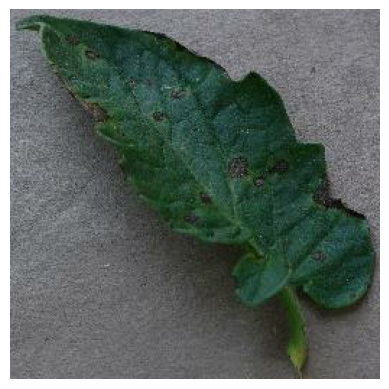

Actual label: Tomato_Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
Predicted label: Tomato_Early_blight


In [21]:
import numpy as np
import matplotlib.pyplot as plt  # Don't forget to import this if not already done

for images_batch, labels_batch in test_ds.take(1):

    second_image = images_batch[1].numpy().astype('uint8')  # Index 1 for second image
    second_label = labels_batch[1].numpy()

    print("Second image to predict:")
    plt.imshow(second_image)
    plt.axis('off')  # Optional: hide axis
    plt.show()

    print("Actual label:", class_names[second_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[1])])  # Index 1 for second prediction


Third image to predict:


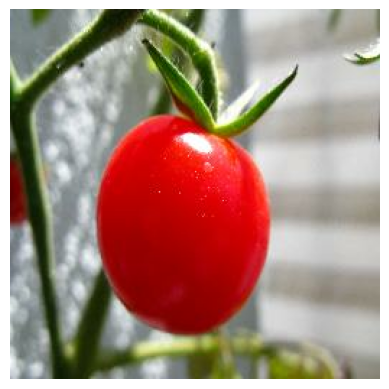

Actual label: Tomato_healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
Predicted label: Tomato_Late_blight


In [22]:
import numpy as np
import matplotlib.pyplot as plt  # Ensure this is imported

for images_batch, labels_batch in test_ds.take(1):

    third_image = images_batch[2].numpy().astype('uint8')  # Third image (index 2)
    third_label = labels_batch[2].numpy()  # Actual label of the third image

    print("Third image to predict:")
    plt.imshow(third_image)
    plt.axis('off')  # Hide axis (optional)
    plt.show()

    print("Actual label:", class_names[third_label])  # True label

    batch_prediction = model.predict(images_batch)  # Predict for whole batch
    print("Predicted label:", class_names[np.argmax(batch_prediction[2])])  # Third prediction


**Write a function for inference**

In [23]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

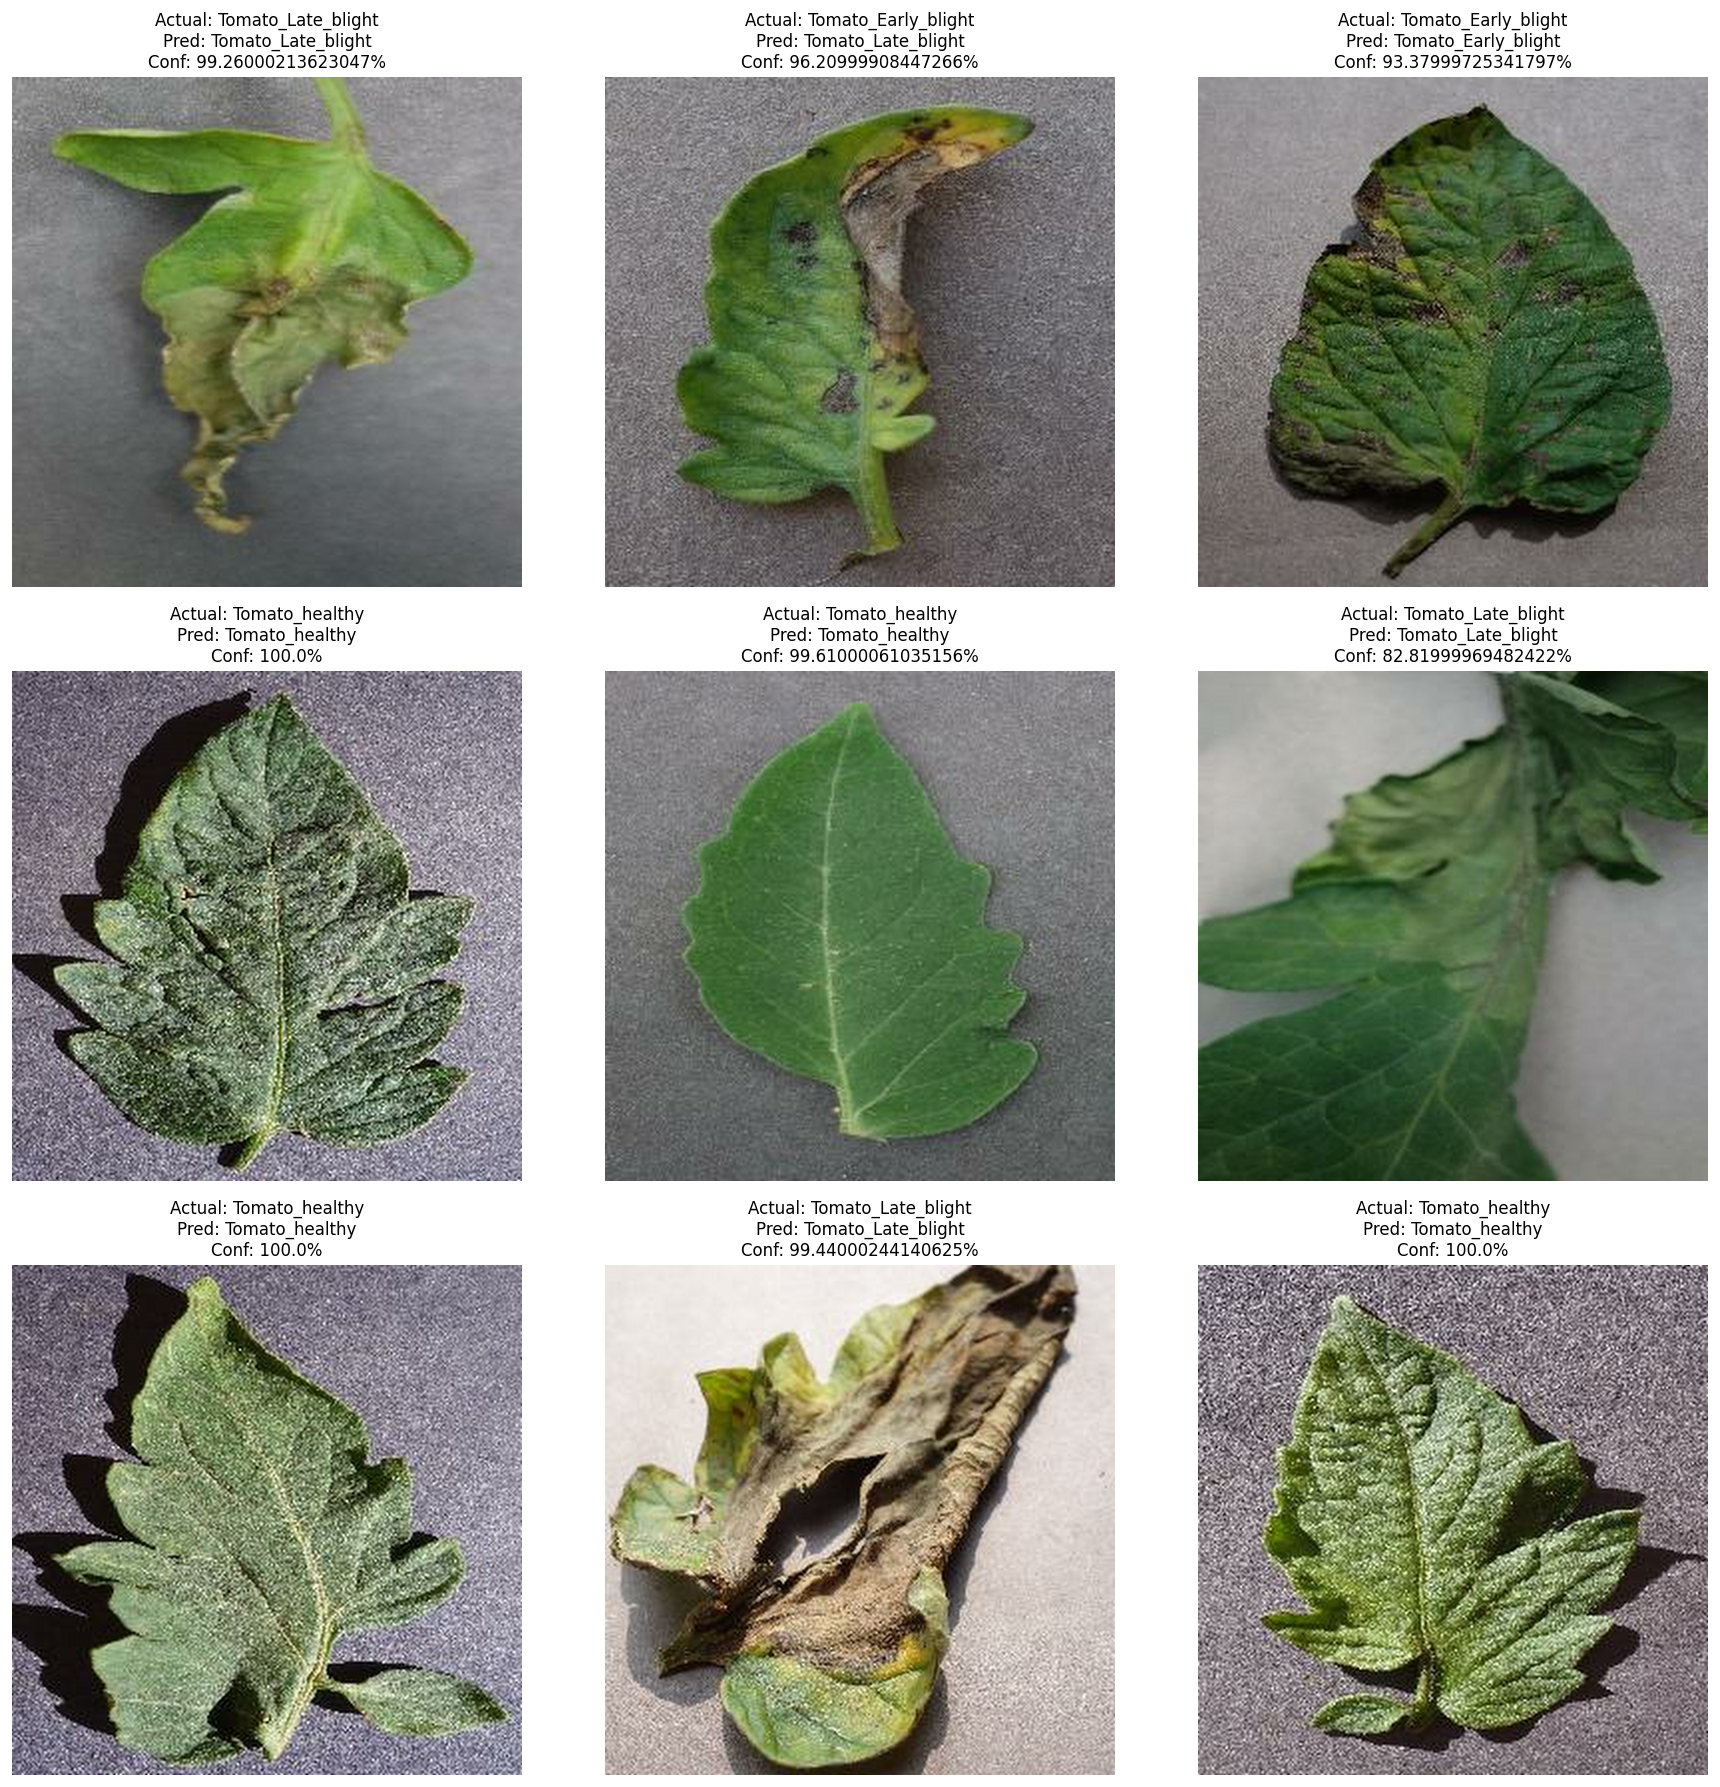

In [24]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 15), dpi=120)  # High-resolution figure

# Use your actual test dataset (e.g., test_ds, test_loader, or test_generator)
for images, labels in test_ds.take(1):  # Replace `test_ds` with your dataset
    for i in range(min(9, len(images))):  # Handle batches with <9 images
        ax = plt.subplot(3, 3, i + 1)

        # Convert tensor to numpy if needed
        img = images[i].numpy() if hasattr(images[i], 'numpy') else images[i]

        # Display image (adjust normalization if needed)
        if img.max() <= 1.0:
            plt.imshow(img, interpolation='lanczos')  # Assuming [0,1]
        else:
            plt.imshow(img.astype('uint8'), interpolation='lanczos')  # Assuming [0,255]

        # Get predictions (replace with your actual prediction function)
        pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
        predicted_class = class_names[np.argmax(pred)]
        confidence = round(100 * np.max(pred), 2)
        actual_class = class_names[int(labels[i])]

        plt.title(f"Actual: {actual_class}\nPred: {predicted_class}\nConf: {confidence}%", fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    break  # Only show first batch

In [25]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# Save your trained model to the TOMATOS DISEASE folder
model.save('/content/drive/MyDrive/TOMATOS DISEASE/model_resnet50.h5')


In [27]:
model.save('model_resnet50.h5')  # Saved in Colab VM


In [ ]:
!cp "/content/drive/MyDrive/TOMATOS DISEASE/model_resnet50.h5" "/content/model_resnet50.h5"


In [28]:
from google.colab import files
files.download('model_resnet50.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/TOMATOS DISEASE/model_resnet50.h5')


In [29]:
with open('requirements.txt', 'w') as f:
    f.write('tensorflow==2.15.0\nnumpy==1.24.3\nmatplotlib==3.7.1\nstreamlit==1.30.0')


In [30]:
model.save("model_resnet50.h5")
